In [1]:
import pandas as pd
from fpl import (
    Loader,
    Player,
    find_matching_players,
    compute_points_per_game,
    compute_form,
)

## Expected Points Model

Using the framework of [General Model Theory](https://en.wikipedia.org/wiki/Model)

##### Mapping - what phenomena are we trying to model?
Given that a player plays a particular fixture (greater than zero minutes played), we want to model how many points the player will score.

##### Reduction - what simplifying assumptions will we make?
The simplifying assumptions we will make are as follows:
- Points scored depends only on fixture difficulty, form and points per game (again, only games where a player plays more than zero minutes)
- There will be no attempt to estimate minutes of each player or likelihood of playing; the effect of minutes will come indirectly through points per game
- There will be no attempt to use other useful statistics from other data sources such as betting odds, opta data, xG etc
- We will restrict our data for analysis to gameweeks 20-24 so that averages are not calculated over so few gameweeks

##### Pragmatism - when can we use the model from a practical point of view?
We can use this model if, for each fixture each player plays, we can calculate:
1. Their points per game so far that season, prior to the fixture.
2. Their form so far than season prior to the fixture.
3. An indication of the difficulty of a particular fixture.

This should be relatively simple, therefore we can create an `ExpectedPointsCalculator` from such a model and plug it into our `Optimizer`.

In [2]:
records = []
for player_id in range(1, len(Loader.get_static_info()["elements"])):
    player_info = Loader.get_player_basic_info(player_id)
    for gameweek in [20, 21, 22, 23, 24]:
        points_per_game = compute_points_per_game(player_id, gameweek)
        form = compute_form(player_id, gameweek)
        gameweek_info = Loader.get_player_historical_info_for_gameweek(
            player_id, gameweek
        )
        # A player can play multiple fixtures in a single gameweek i.e. a "double" gameweek
        for fixture_info in gameweek_info:
            team_id = player_info["team"]
            team_info = Loader.get_team_basic_info(team_id)
            opponent_team_id = fixture_info["opponent_team"]
            opponent_team_info = Loader.get_team_basic_info(opponent_team_id)
            if fixture_info["minutes"] == 0:
                continue
            else:
                records.append(
                    {
                        "player_id": player_id,
                        "gameweek": gameweek,
                        "fixture": fixture_info["fixture"],
                        "web_name": player_info["web_name"],
                        "team": team_info["short_name"],
                        "opponent_team": opponent_team_info["short_name"],
                        "team_id": team_id,
                        "opponent_team_id": opponent_team_id,
                        "was_home": fixture_info["was_home"],
                        "position": player_info["element_type"],
                        "total_points": fixture_info["total_points"],  # response
                        "form": form,  # predictor
                        "points_per_game": points_per_game,  # predictor
                    }
                )

In [3]:
df = pd.DataFrame(records)

In [4]:
df[df["player_id"] == 328]

,player_id,gameweek,fixture,web_name,team,opponent_team,team_id,opponent_team_id,was_home,position,total_points,form,points_per_game
760,328,20,196,M.Salah,LIV,MUN,12,14,True,3,7,12.8,11.2
761,328,21,206,M.Salah,LIV,NFO,12,16,False,3,2,13.2,11.0
762,328,22,212,M.Salah,LIV,BRE,12,4,False,3,3,11.0,10.6
763,328,23,226,M.Salah,LIV,IPS,12,10,True,3,8,7.4,10.2
764,328,24,232,M.Salah,LIV,BOU,12,3,False,3,16,5.0,10.1
765,328,24,144,M.Salah,LIV,EVE,12,8,False,3,13,5.0,10.1


TODO:
- Do some exploratory data analysis and tire kick to see if it's ok
- Do regression and get some visualizations

In [5]:
import matplotlib.pyplot as plt

plt.style.use("bmh")

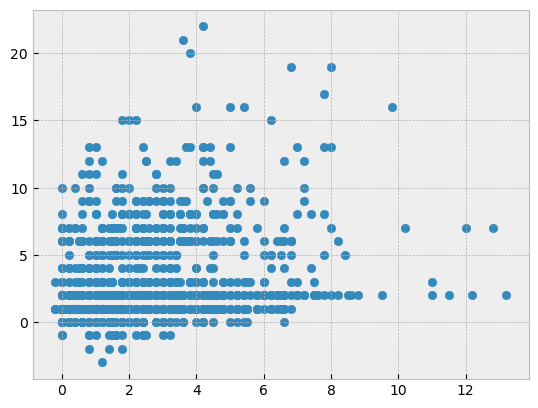

In [6]:
plt.scatter(x=df["form"], y=df["total_points"])

,total_points,form,points_per_game,position
total_points,1.000000,0.264071,0.334214,0.080320
form,0.264071,1.000000,0.756479,0.057802
points_per_game,0.334214,0.756479,1.000000,0.055633
position,0.080320,0.057802,0.055633,1.000000


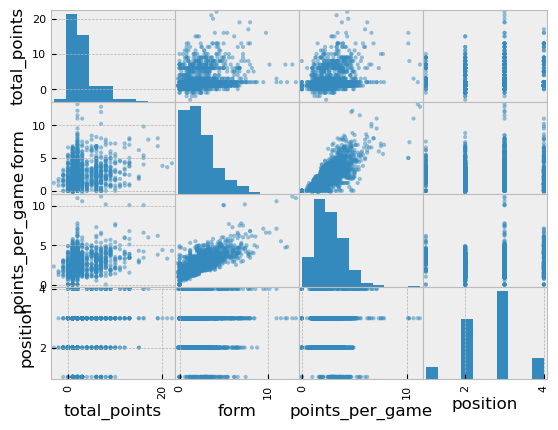

In [7]:
pd.plotting.scatter_matrix(df[["total_points", "form", "points_per_game", "position"]])
df[["total_points", "form", "points_per_game", "position"]].corr()

In [8]:
df_train = df[df["gameweek"] != 24]
df_test = df[df["gameweek"] == 24]